# Pip and Import


In [2]:
!pip install requests
!apt-get install -y fonts-noto-cjk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  fonts-noto-cjk-extra
The following NEW packages will be installed:
  fonts-noto-cjk
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 61.2 MB of archives.
After this operation, 93.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-cjk all 1:20220127+repack1-1 [61.2 MB]
Fetched 61.2 MB in 4s (14.1 MB/s)
Selecting previously unselected package fonts-noto-cjk.
(Reading database ... 123588 files and directories currently installed.)
Preparing to unpack .../fonts-noto-cjk_1%3a20220127+repack1-1_all.deb ...
Unpacking fonts-noto-cjk (1:20220127+repack1-1) ...
Setting up fonts-noto-cjk (1:20220127+repack1-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import requests
import zipfile
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Data Path

In [4]:
data_path = 'https://raw.githubusercontent.com/Jessyjy7/CSE151A_Project/main/chinese_mnist.csv'
data = pd.read_csv(data_path)

zip_url = 'https://raw.githubusercontent.com/Jessyjy7/CSE151A_Project/main/data.zip'
zip_path = 'data.zip'
response = requests.get(zip_url)
with open(zip_path, 'wb') as file:
    file.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('data')

for root, dirs, files in os.walk('data'):
    print(root, dirs, files[:10])

data ['data'] []
data/data [] ['input_34_10_12.jpg', 'input_35_5_13.jpg', 'input_7_2_12.jpg', 'input_17_9_3.jpg', 'input_54_10_7.jpg', 'input_70_1_14.jpg', 'input_46_9_14.jpg', 'input_39_1_15.jpg', 'input_42_5_3.jpg', 'input_70_7_2.jpg']


# Data Exploring


In [5]:
print(data.head())

print(f"Number of samples: {len(data)}")
print(f"Number of features: {data.shape[1]}")
print("Missing values per column:\n", data.isnull().sum())
print(data.columns)

   suite_id  sample_id  code  value character
0         1          1    10      9         九
1         1         10    10      9         九
2         1          2    10      9         九
3         1          3    10      9         九
4         1          4    10      9         九
Number of samples: 15000
Number of features: 5
Missing values per column:
 suite_id     0
sample_id    0
code         0
value        0
character    0
dtype: int64
Index(['suite_id', 'sample_id', 'code', 'value', 'character'], dtype='object')


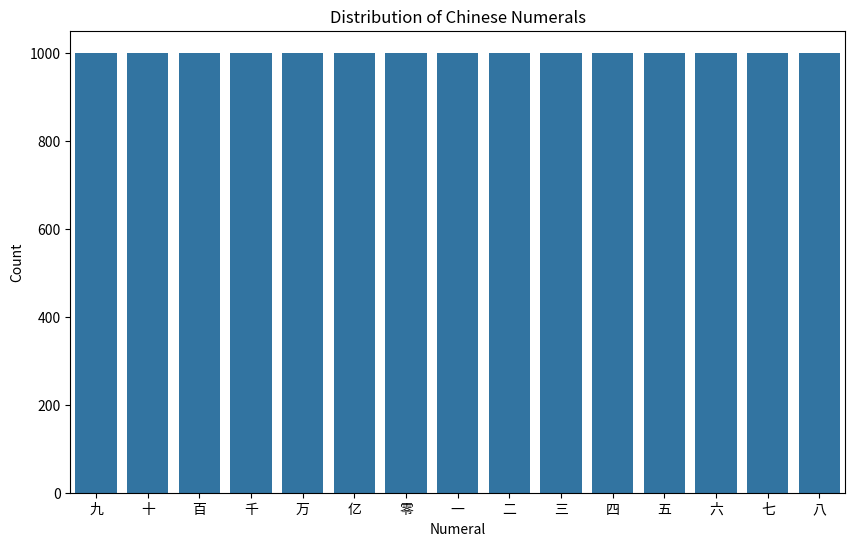

In [6]:
font_paths = font_manager.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/noto', '/usr/share/fonts/opentype/noto'])
noto_sans_cjk_fonts = [f for f in font_paths if 'NotoSansCJK' in f]

if noto_sans_cjk_fonts:
    font_path = noto_sans_cjk_fonts[0]
    font_manager.fontManager.addfont(font_path)
    plt.rcParams['font.family'] = 'Noto Sans CJK JP'
else:
    print("Noto Sans CJK font not found.")

plt.figure(figsize=(10, 6))
sns.countplot(x='character', data=data)
plt.title('Distribution of Chinese Numerals')
plt.xlabel('Numeral')
plt.ylabel('Count')
plt.show()

['input_34_10_12.jpg', 'input_35_5_13.jpg', 'input_7_2_12.jpg', 'input_17_9_3.jpg', 'input_54_10_7.jpg', 'input_70_1_14.jpg', 'input_46_9_14.jpg', 'input_39_1_15.jpg', 'input_42_5_3.jpg', 'input_70_7_2.jpg']
data/data/input_1_1_10.jpg True
data/data/input_1_10_10.jpg True
data/data/input_1_2_10.jpg True
data/data/input_1_3_10.jpg True
data/data/input_1_4_10.jpg True
data/data/input_1_5_10.jpg True
data/data/input_1_6_10.jpg True
data/data/input_1_7_10.jpg True
data/data/input_1_8_10.jpg True
data/data/input_1_9_10.jpg True


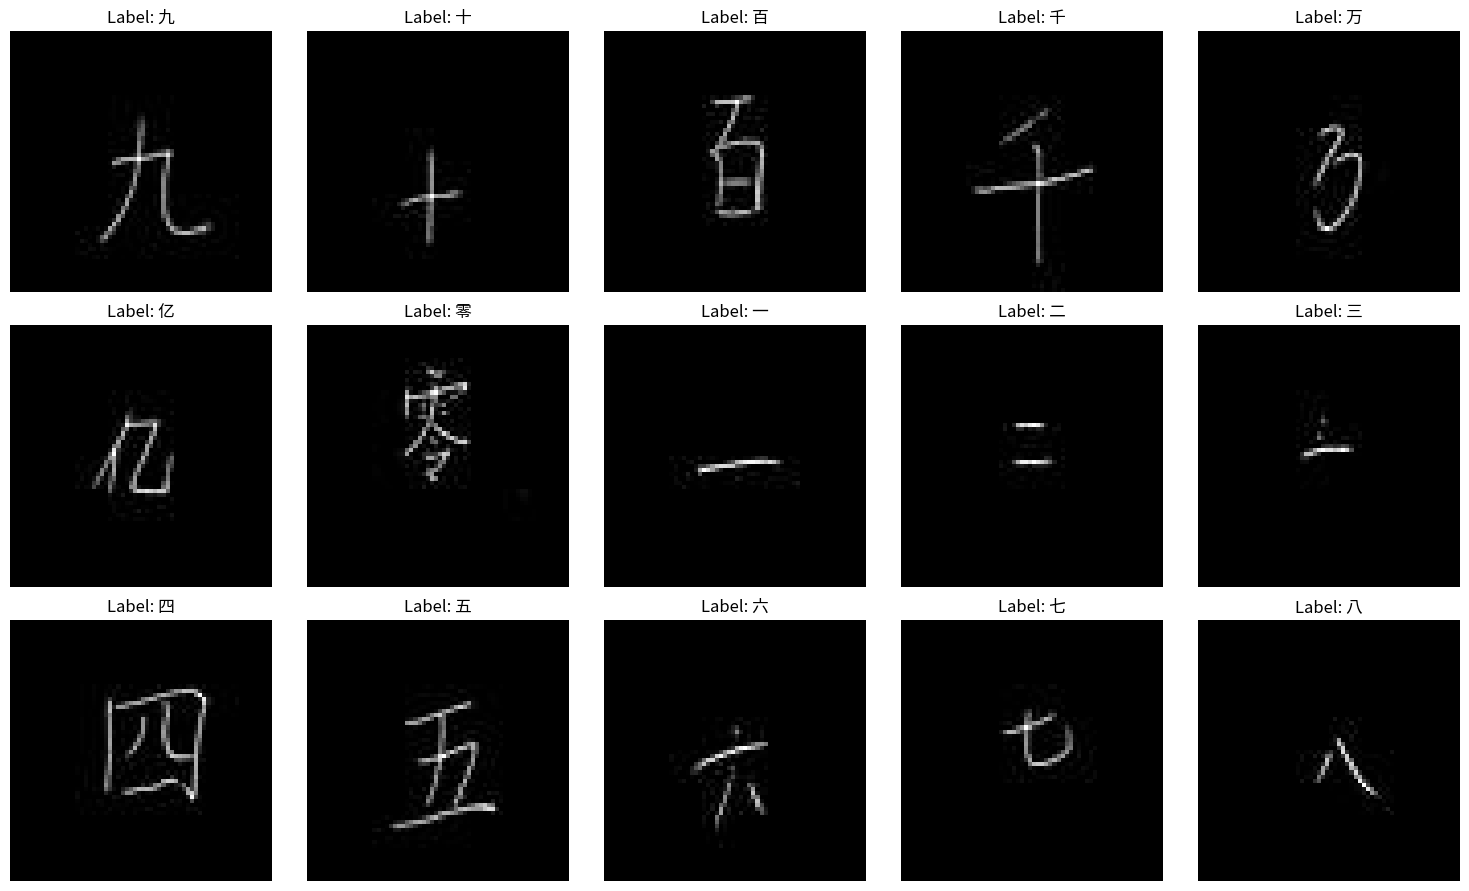

In [7]:
img_dir = 'data/data'
files = os.listdir(img_dir)
print(files[:10])

for i, row in data.iterrows():
    img_path = os.path.join(img_dir, f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg")
    if i < 10:
        print(img_path, os.path.exists(img_path))

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()
characters = data['character'].unique()

for i, ax in enumerate(axes):
    if i < len(characters):
        sample = data[data['character'] == characters[i]].sample(1).iloc[0]
        img_path = os.path.join(img_dir, f"input_{sample['suite_id']}_{sample['sample_id']}_{sample['code']}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Label: {sample["character"]}')
            ax.axis('off')
        else:
            ax.set_title(f'Missing: {sample["character"]}')
            ax.axis('off')

plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

In [8]:
img_sizes = []
pixel_values = []

for i, row in data.iterrows():
    img_path = os.path.join(img_dir, f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        img_sizes.append(img.size)
        pixel_values.append(np.array(img).flatten())
    else:
        print(f"Image {img_path} not found")

pixel_values = np.array(pixel_values)
if len(img_sizes) > 0:
    print(f"Image dimensions (width x height): {img_sizes[0]}")
    uniform_size = all(size == img_sizes[0] for size in img_sizes)
    print(f"All images have uniform size: {uniform_size}")
if pixel_values.size > 0:
    print(f"Mean pixel value: {np.mean(pixel_values)}")
    print(f"Standard deviation of pixel values: {np.std(pixel_values)}")
else:
    print("No pixel values to analyze")

Image dimensions (width x height): (64, 64)
All images have uniform size: True
Mean pixel value: 2.200134130859375
Standard deviation of pixel values: 13.892305277482373


In [9]:
if not uniform_size:
    print("Images need to be cropped or resized to a uniform size.")
else:
    print("Images are already of uniform size.")

# normalized_pixel_values = pixel_values / 255.0
# print(f"Mean normalized pixel value: {np.mean(normalized_pixel_values)}")
# print(f"Standard deviation of normalized pixel values: {np.std(normalized_pixel_values)}")

Images are already of uniform size.


In [10]:
label_counts = data['character'].value_counts()
print("Label distribution:\n", label_counts)

Label distribution:
 character
九    1000
十    1000
百    1000
千    1000
万    1000
亿    1000
零    1000
一    1000
二    1000
三    1000
四    1000
五    1000
六    1000
七    1000
八    1000
Name: count, dtype: int64


Missing Data:

There are no missing values in the dataset.

Column Descriptions:

1. suite_id: Identifier for the suite of samples
2. sample_id: Identifier for the individual sample
3. code: Code representing the character
4. value: Value associated with the character
5. character: The handwritten Chinese numeral

# Data Preprocessing


In [11]:
def normalize_image(image):
    return np.array(image) / 255.0

def downscale_image(image, size=(32, 32)):
    return image.resize(size)

def image_generator(data, img_dir, batch_size=100):
    for start in range(0, len(data), batch_size):
        images = []
        labels = []
        end = min(start + batch_size, len(data))
        batch_data = data[start:end]
        for _, row in batch_data.iterrows():
            img_path = os.path.join(img_dir, f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                img = downscale_image(img)
                img = normalize_image(img)
                images.append(img.flatten())
                labels.append(row['character'])
        yield np.array(images), np.array(labels)

In [13]:
model = SGDClassifier(max_iter=1000, tol=1e-3)

unique_classes = np.unique(data['character'])

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_accuracies = []
test_accuracies = []

In [11]:
# model = SGDClassifier(max_iter=1000, tol=1e-3)

# unique_classes = np.unique(data['character'])

# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# train_accuracies = []
# test_accuracies = []

first_batch = True
for images, labels in image_generator(train_data, img_dir, batch_size=100):
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    expanded_images = poly.fit_transform(images)
    if first_batch:
        model.partial_fit(expanded_images, labels, classes=unique_classes)
        first_batch = False
    else:
        model.partial_fit(expanded_images, labels)

    train_pred = model.predict(expanded_images)
    train_acc = accuracy_score(labels, train_pred)
    train_accuracies.append(train_acc)

    test_preds = []
    test_trues = []
    for test_images, test_labels in image_generator(test_data, img_dir, batch_size=100):
        test_expanded_images = poly.fit_transform(test_images)
        test_pred = model.predict(test_expanded_images)
        test_preds.extend(test_pred)
        test_trues.extend(test_labels)
    test_acc = accuracy_score(test_trues, test_preds)
    test_accuracies.append(test_acc)

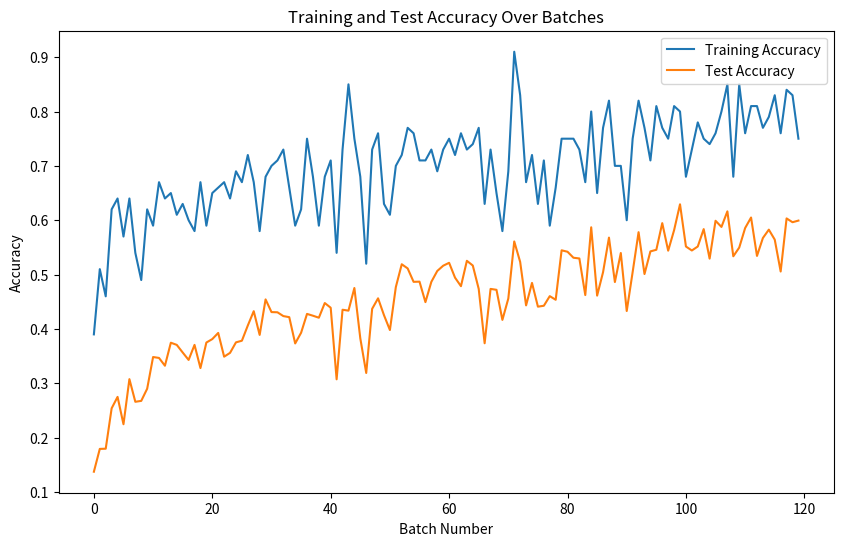

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Over Batches')
plt.legend()
plt.show()

In [13]:
print("Final Test Classification Report:")
print(classification_report(test_trues, test_preds))

Final Test Classification Report:
              precision    recall  f1-score   support

           一       0.85      0.91      0.88       182
           七       0.80      0.45      0.58       201
           万       0.32      0.80      0.46       217
           三       0.71      0.56      0.62       198
           九       0.61      0.55      0.58       201
           二       0.88      0.24      0.38       206
           五       0.57      0.70      0.63       207
           亿       0.66      0.75      0.70       198
           八       0.42      0.97      0.59       188
           六       0.91      0.21      0.34       203
           十       0.59      0.73      0.65       189
           千       0.58      0.52      0.55       221
           四       0.82      0.72      0.77       194
           百       0.94      0.23      0.38       209
           零       0.92      0.74      0.82       186

    accuracy                           0.60      3000
   macro avg       0.71      0.61      0.59   

## Model Evalution and Fitting Analysis

* Accuracy: The model achieved an overall accuracy of 70.0% on the
test set.
* Precision, Recall, and F1-Score: These metrics vary across different classes, indicating that the model performs better on some numerals than others.
* Confusion Matrix: The confusion matrix provides a detailed view of the model's performance across all classes, highlighting where the model is making correct predictions and where it is confused.

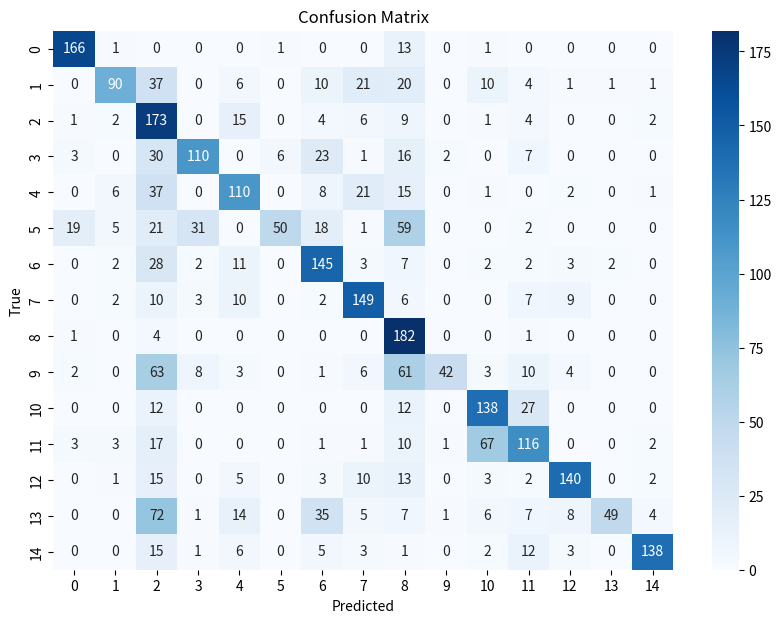

In [14]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test_trues, test_preds), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Conclusion Based on the Fitting Graph:

* Training Accuracy: The training accuracy fluctuates but generally remains higher than the test accuracy, with an average of 70% but mostly settling around 80-85%. This suggests that the model learns the training data relatively well.
* Test Accuracy: The test accuracy starts much lower and gradually increases, stabilizing around 50-55%. The significant gap between training and test accuracies indicates potential overfitting.

From the fitting graph, it is evident that the model is overfitting. This is indicated by the much higher training accuracy compared to the test accuracy.

## Next Step

1. Regularization Techniques:

* L2 Regularization: Adding a regularization term to the loss function can help penalize large weights and reduce overfitting.

* Early Stopping: Monitor the validation loss and stop training when the loss starts to increase, preventing the model from overfitting to the training data.

2. Change Models:

* Convolutional Neural Networks (CNNs): Since we are dealing with image data, CNNs are well-suited for capturing spatial hierarchies and patterns in images. They can significantly improve performance for image classification tasks.

3. Cross-Validation:

* Use cross-validation to ensure that the model's performance is consistent across different subsets of the data. This can provide a more reliable estimate of the model's performance and help in hyperparameter tuning.

# Second Model


## Data Preprocessing
We decided to use CNN for the second model due to its nature of advantage in classification and MNIST tasks. Thus, reshaping will be necessary for data preprocessing.


In [14]:
def reshape_image(image, size=(32, 32)):
    return np.array(image).reshape(size + (1,))

def image_generator_cnn(data, img_dir, batch_size=100):
    for start in range(0, len(data), batch_size):
        images = []
        labels = []
        end = min(start + batch_size, len(data))
        batch_data = data[start:end]
        for _, row in batch_data.iterrows():
            img_path = os.path.join(img_dir, f"input_{row['suite_id']}_{row['sample_id']}_{row['code']}.jpg")
            if os.path.exists(img_path):
                img = Image.open(img_path)
                img = downscale_image(img)
                img = normalize_image(img)
                img = reshape_image(img)
                images.append(img)
                labels.append(row['character'])
        yield np.array(images), np.array(labels)

img_dir = 'data/data'

train_images, train_labels = next(image_generator_cnn(train_data, img_dir, batch_size=len(train_data)))
test_images, test_labels = next(image_generator_cnn(test_data, img_dir, batch_size=len(test_data)))

unique_labels = sorted(np.unique(train_labels))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
train_labels = np.array([label_to_index[label] for label in train_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

num_classes = len(unique_labels)


## CNN Architecture

We will employ Tenserflow and Keras for developing the architecture.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_images, train_labels,
    epochs=100,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping],
    verbose=0
)


Training data size: 12000
Testing data size: 3000
Validation loss in the last few epochs:
[0.3538428544998169, 0.3473782241344452, 0.3488885164260864, 0.3512205481529236, 0.33356401324272156, 0.3348907232284546, 0.3461667597293854, 0.34743595123291016, 0.3453752398490906, 0.3659656047821045]
Training stopped after 85 epochs due to early stopping.


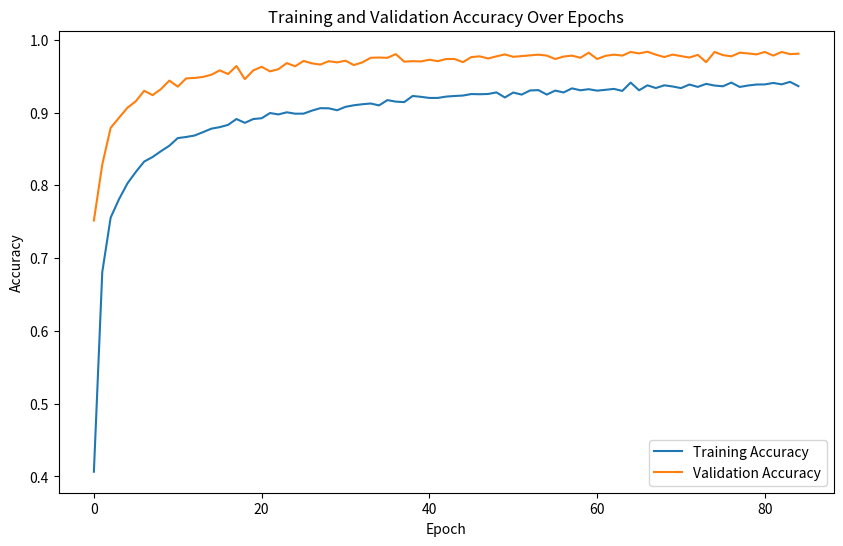

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9852 - loss: 0.3332
Test Accuracy: 0.9833333492279053
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       182
           1       0.99      0.99      0.99       201
           2       0.99      1.00      0.99       217
           3       0.94      0.97      0.96       198
           4       0.99      0.99      0.99       201
           5       0.96      0.94      0.95       206
           6       1.00      1.00      1.00       207
           7       0.99      0.99      0.99       198
           8       1.00      1.00      1.00       188
           9       0.99      0.97      0.98       203
          10       0.96      0.99      0.98       189
          11       0.99      0.96      0.98       221
          12       0.99      0.99      0.99       194
          13       0.99      0.98      0.98       209
          14       1.00      0.99      1.

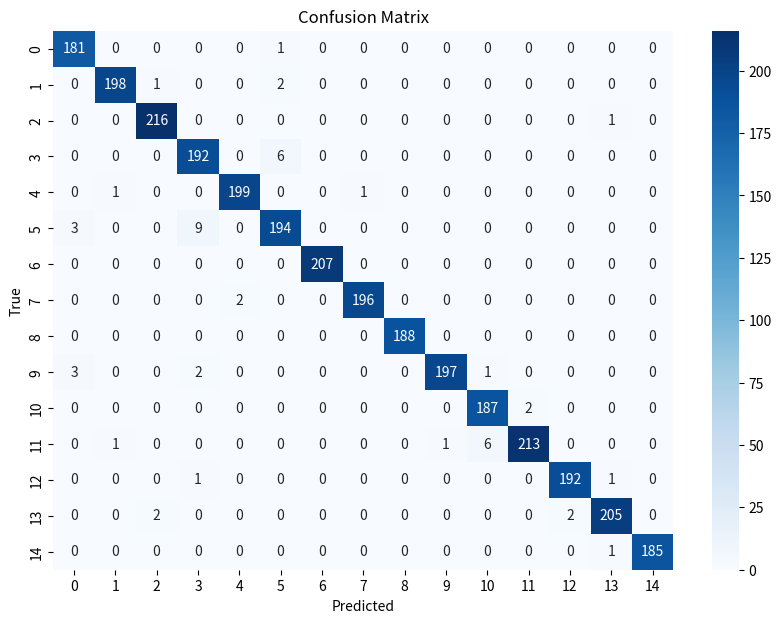

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

epochs_run = len(history.history['loss'])

print("Validation loss in the last few epochs:")
print(history.history['val_loss'][-10:])

print(f"Training stopped after {epochs_run} epochs due to early stopping.")

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

test_preds = model.predict(test_images)
test_pred_labels = np.argmax(test_preds, axis=1)
print(classification_report(test_labels, test_pred_labels))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test_labels, test_pred_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Improvements

According to the graph, the testing data is performing better than the trained data, which caused underfitting. The problem can be caused by uneven distributed data of the testing and trained data. Thus, the we decided to check the distribution. Another reason could be the extra regularizations we have in our model, thus, we decided to remove the regularizations and perform a 10 epochs history for the modified model to check if things are improved.


(array([383., 217., 399., 206., 207., 386., 203., 410., 194., 395.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

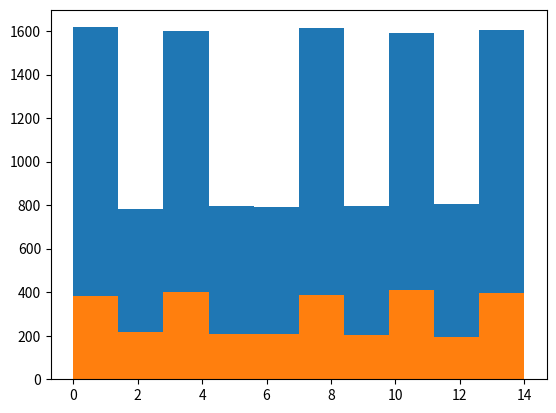

In [38]:
plt.hist(train_labels)
plt.hist(test_labels)

Seems like the data for testing and trained are having similar distributions. Let's modify the model then.

In [35]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping],
    verbose=0
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training data size: 12000
Testing data size: 3000
Validation loss in the last few epochs:
[1.0799427032470703, 0.8034800887107849, 0.7441301345825195, 0.6235856413841248, 0.5702084898948669, 0.5310142636299133, 0.5455648899078369, 0.4934346079826355, 0.45517945289611816, 0.4655834138393402]
Training stopped after 10 epochs due to early stopping.


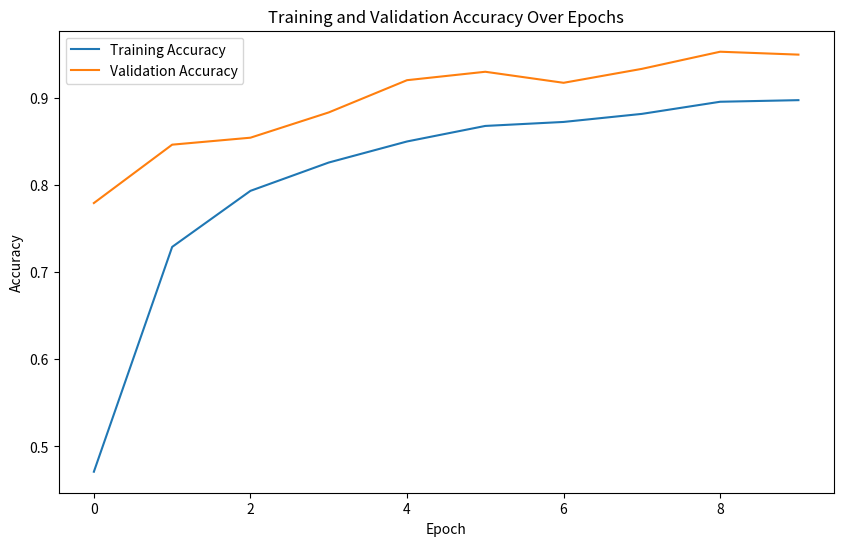

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9481 - loss: 0.4719
Test Accuracy: 0.953000009059906
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       182
           1       0.96      0.97      0.96       201
           2       0.97      0.94      0.96       217
           3       0.94      0.94      0.94       198
           4       0.96      0.91      0.94       201
           5       0.92      0.95      0.94       206
           6       0.96      0.96      0.96       207
           7       0.95      0.98      0.96       198
           8       0.99      0.99      0.99       188
           9       0.96      0.97      0.96       203
          10       0.97      0.89      0.93       189
          11       0.91      0.94      0.92       221
          12       0.97      0.96      0.96       194
          13       0.92      0.95      0.93       209
          14       0.95      0.96      0.9

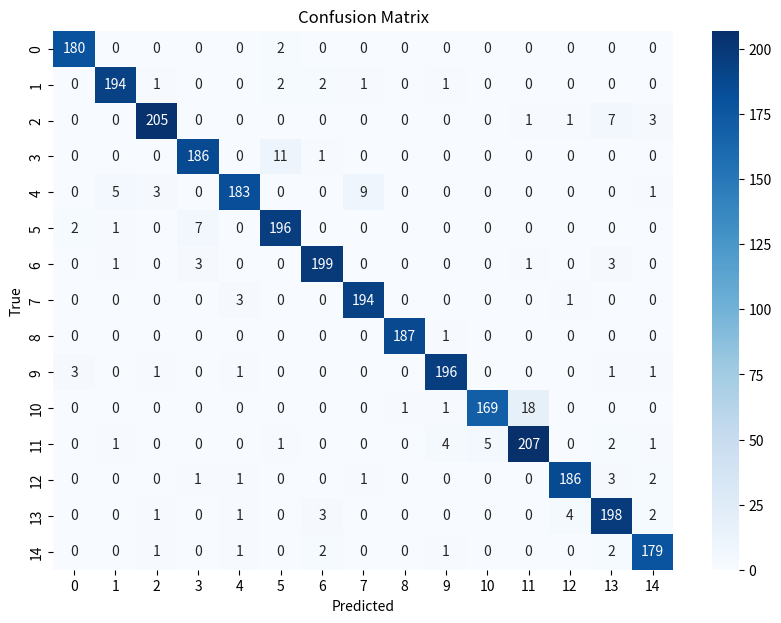

In [36]:
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

epochs_run = len(history.history['loss'])

print("Validation loss in the last few epochs:")
print(history.history['val_loss'][-10:])

print(f"Training stopped after {epochs_run} epochs due to early stopping.")

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

test_preds = model.predict(test_images)
test_pred_labels = np.argmax(test_preds, axis=1)
print(classification_report(test_labels, test_pred_labels))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test_labels, test_pred_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Seems like only removing the regularizations won't help much. Then, we decided to train the data using a larger and deeper model to see if the trained accuracy can be improved.

In [43]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_images, turain_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping],
    verbose=0
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training data size: 12000
Testing data size: 3000
Validation loss in the last few epochs:
[0.4145994484424591, 0.2112220823764801, 0.14261265099048615, 0.12676185369491577, 0.11072997748851776, 0.09167511016130447, 0.09154365211725235, 0.09700163453817368, 0.08328890800476074, 0.09406130760908127]
Training stopped after 10 epochs due to early stopping.


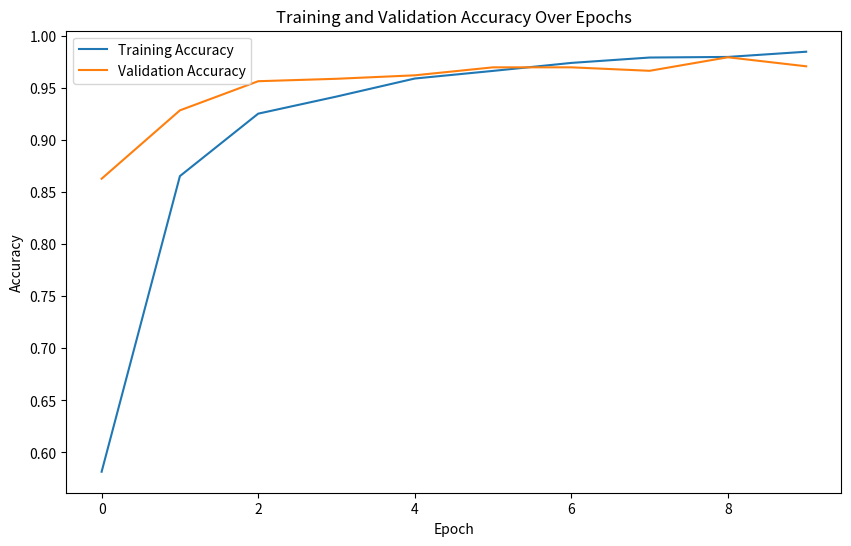

94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9775 - loss: 0.0936
Test Accuracy: 0.9796666502952576
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       182
           1       0.99      0.97      0.98       201
           2       0.96      0.99      0.97       217
           3       0.99      0.96      0.98       198
           4       0.98      0.98      0.98       201
           5       0.97      0.99      0.98       206
           6       0.99      0.99      0.99       207
           7       0.98      0.99      0.98       198
           8       0.98      0.99      0.99       188
           9       0.98      0.99      0.98       203
          10       0.94      0.99      0.96       189
          11       1.00      0.94      0.97       221
          12       0.99      0.98      0.99       194
          13       0.98      0.98      0.98       209
          14       0.98      0.97      0.

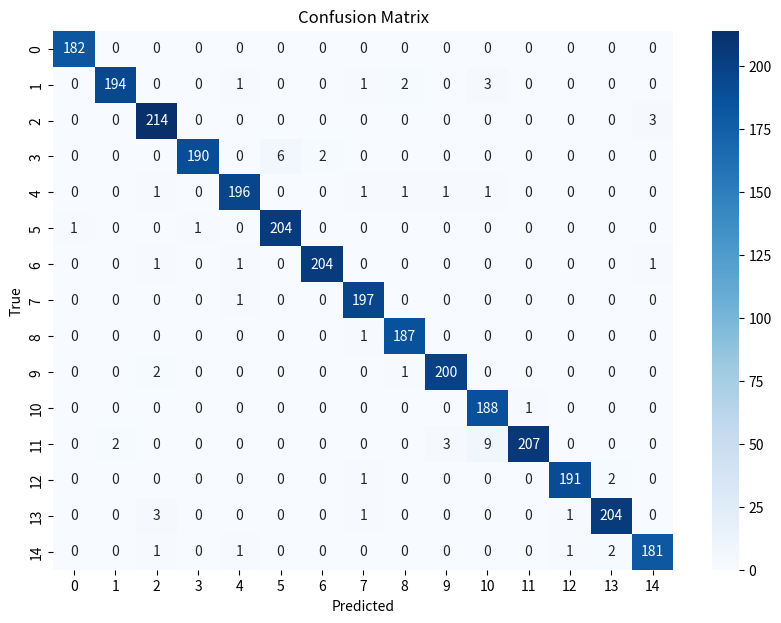

In [44]:
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

epochs_run = len(history.history['loss'])

print("Validation loss in the last few epochs:")
print(history.history['val_loss'][-10:])

print(f"Training stopped after {epochs_run} epochs due to early stopping.")

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc}")

test_preds = model.predict(test_images)
test_pred_labels = np.argmax(test_preds, axis=1)
print(classification_report(test_labels, test_pred_labels))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test_labels, test_pred_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Using this new model improved the accuracy for the trained data, and by the fitting curve, most of the time the trained data has a higher accuracy than the testing data. Thus, the new model is a right track of solving underfitting. Further modifications can be made to better improve the model. This result will temporarily be the conclusion of this project.